# Prepare Environment

Load necessary modules and attempt to compile the GrOpt library if it isn't already

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import gropt
from helper_utils import *

%matplotlib inline

# GrOpt

### Gradient design toolbox 
#### Written in C (for compiling on scanners), with wrappers in Python and Matlab for prototyping

Ideally **_any_** waveform can be described by a set of constraints

Currently implemented in various forms on Siemens and GE scanners

***

## Example 1: Phase Encoding Gradient

#### Constraints on:
- Maximum gradient amplitude
- Maximum slew rate
- 0th moment = 11.74 (mT*ms)/m = The area needed to encode a 1mm spatial resolution line in k-space

Waveform duration = 0.63 ms


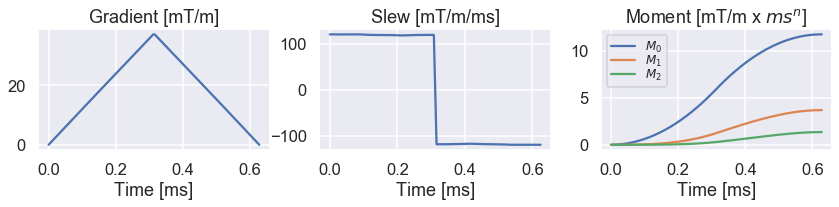

In [2]:
params = {}

params['mode'] = 'free' # Free mode indicates we are in a feasibility search, i.e. no objective function

# Set hardware limits
params['gmax'] = 50    # Maximum gradient amplitude, mT/m
params['smax'] = 120.0  # Maximum slew rate, mT/m/ms 

# Moment parameters have a lot of options, reading the docs is necessary
# Currently, the input moment parameters to know are: 
# 2nd (moment of interest, 0th), 6th (desired 0th moment, 11.75), and 7th (moment tolerance, 1.0e-3) 
params['moment_params'] = [[0, 0, 0, -1, -1, 11.75, 1.0e-3]]

params['dt'] = 4e-6 # Raster time of the gradient waveform being optimized


G, T_min = get_min_TE(params, max_TE = 2) # max_TE = 2 means it will search all waveforms between 0 and 2ms
print('Waveform duration =', round(T_min,2), 'ms')
plot_waveform(G, params, plot_moments = True, plot_eddy = False, plot_pns = False, plot_slew = True)

#### Reducing gmax to see its effect:

Waveform duration = 0.76 ms


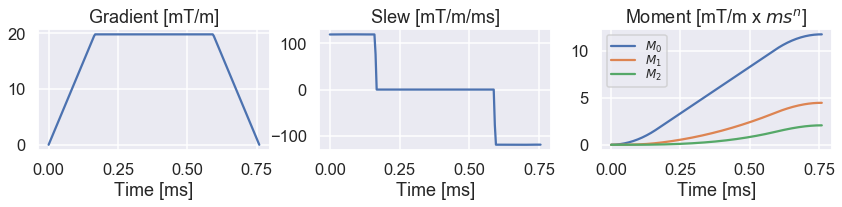

In [3]:
params = {}
params['mode'] = 'free'

# ************
# gmax changed to 20 mT/m 
# ************
params['gmax'] = 20
params['smax'] = 120.0

params['moment_params'] = [[0, 0, 0, -1, -1, 11.75, 1.0e-3]]
params['dt'] = 4e-6


G, T_min = get_min_TE(params, max_TE = 2)
print('Waveform duration =', round(T_min,2), 'ms')
plot_waveform(G, params, plot_moments = True, plot_eddy = False, plot_pns = False, plot_slew = True)

#### Adding velocity compensation (add a constraint on M1 to be 0):

Waveform duration = 1.42 ms


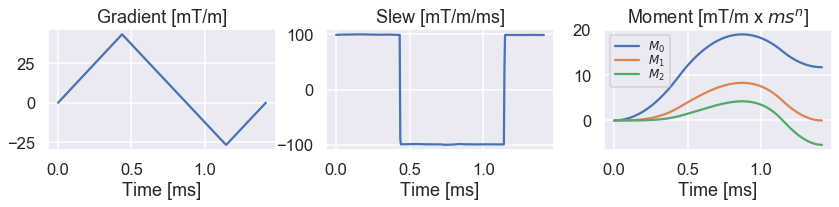

In [4]:
params = {}
params['mode'] = 'free'

params['gmax'] = 50
params['smax'] = 100.0

params['moment_params'] = [[0, 0, 0, -1, -1, 11.75, 1.0e-3]]
# ************
# Additional moment constraint added on M1 = 0
# ************
params['moment_params'].append([0, 1, 0, -1, -1, 0, 1.0e-3])
params['dt'] = 4e-6


G, T_min = get_min_TE(params, max_TE = 2.5)
print('Waveform duration =', round(T_min,2), 'ms')
plot_waveform(G, params, plot_moments = True, plot_eddy = False, plot_pns = False, plot_slew = True)

#### Adding acceleration compensation (add a constraint on M2 to be 0):

In [ ]:
params = {}
params['mode'] = 'free'

params['gmax'] = 50
params['smax'] = 100.0

params['moment_params'] = [[0, 0, 0, -1, -1, 11.75, 1.0e-3]]
params['moment_params'].append([0, 1, 0, -1, -1, 0, 1.0e-3])
# ************
# Additional moment constraint added on M2 = 0
# ************
params['moment_params'].append([0, 2, 0, -1, -1, 0, 1.0e-3])
params['dt'] = 4e-6


G, T_min = get_min_TE(params, max_TE = 2.6)
print('Waveform duration =', round(T_min,2), 'ms')
plot_waveform(G, params, plot_moments = True, plot_eddy = False, plot_pns = False, plot_slew = True)

### Peripheral Nerve Stimulation (PNS) control

If we use the full power of the gradient slew rates, the same gradient can be played much faster, but PNS will become problematic

In [ ]:
params = {}
params['mode'] = 'free'

params['gmax'] = 50
# ************
# Increases slew rate to 200
# ************
params['smax'] = 200.0

params['moment_params'] = [[0, 0, 0, -1, -1, 11.75, 1.0e-3]]
params['moment_params'].append([0, 1, 0, -1, -1, 0, 1.0e-3])
params['moment_params'].append([0, 2, 0, -1, -1, 0, 1.0e-3])
params['dt'] = 4e-6


G, T_min = get_min_TE(params, max_TE = 2)
print('Waveform duration =', round(T_min,2), 'ms')
plot_waveform(G, params, plot_moments = True, plot_eddy = False, plot_pns = True, plot_slew = True)

#### We can keep the maximum slew rate (200mT/m/ms) and add a PNS constraint to keep PNS < 1.0

In [ ]:
params = {}
params['mode'] = 'free'

params['gmax'] = 50
params['smax'] = 200.0

params['moment_params'] = [[0, 0, 0, -1, -1, 11.75, 1.0e-3]]
params['moment_params'].append([0, 1, 0, -1, -1, 0, 1.0e-3])
params['moment_params'].append([0, 2, 0, -1, -1, 0, 1.0e-3])
params['dt'] = 40e-6

# ************
# Add PNS contraint
# ************
params['pns_thresh'] = 1.0

G, T_min = get_min_TE(params, min_TE = 1.6, max_TE = 2.2)
print('Waveform duration =', round(T_min,2), 'ms')
plot_waveform(G, params, plot_moments = True, plot_eddy = False, plot_pns = True, plot_slew = True)

## Example 2: Diffusion Encoding Gradients

#### Constraints on:
- Maximum gradient amplitude
- Maximum slew rate
- 0th moment = 0 (mT*ms)/m 
- Add objective function to maximize b-value
- Add constraint to turn gradients off during excitation and refocusing RF pulses
- Account for time spent readout out the data (immiedatley after diffusion gradients until the echo time)

In [ ]:
params = {}
params['mode'] = 'diff_bval'
params['gmax'] = 50            # Maximum gradient amplitude, mT/m
params['smax'] = 100           # Maximum slew rate, mT/m/ms
params['MMT'] = 0              # Nulling M0
params['T_readout'] = 20       # Time from start to center of EPI readout, ms
params['T_90'] = 3             # Duration of excitation pulse, ms
params['T_180'] = 5            # Duration of refocusing pulse, ms
params['b'] = 1000             # Diffusion b-value, s/mm^2
params['dt'] = 400e-6

# Convex Optimized Diffusion Encoding (CODE)
G_min, T_min = get_min_TE(params, bval=params['b'], min_TE = 40, max_TE = 120)
print('Minimum TE =', round(T_min,2), 'ms')
plot_waveform(-1*G_min, params, plot_moments = True, plot_eddy = False, plot_pns = False, plot_slew = True)
plt.show(plot_waveform)

# Conventional Monopolar
Mono, TE, b, params = monopolar_diffusion(params)
params['TE'] = TE/100 + params['T_readout']*1000
print('Minimum TE =', round(params['TE'],2), 'ms')
plot_waveform(Mono, params, plot_moments = True, plot_eddy = False, plot_pns = False, plot_slew = True)
plt.show(plot_waveform)

#### We can constrain for M0=M1=0 for conventional and optimized methods as well

In [ ]:
params = {}
params['mode'] = 'diff_bval'
params['gmax'] = 50            # Maximum gradient amplitude, mT/m
params['smax'] = 100           # Maximum slew rate, mT/m/ms

# ************
# M0 and M1 nulling
# ************
params['MMT'] = 1              # Nulling M1

params['T_readout'] = 20       # Time from start to center of EPI readout, ms
params['T_90'] = 3             # Duration of excitation pulse, ms
params['T_180'] = 5            # Duration of refocusing pulse, ms
params['b'] = 1000             # Diffusion b-value, s/mm^2
params['dt'] = 400e-6

# Convex Optimized Diffusion Encoding (CODE)
G_min, T_min = get_min_TE(params, bval=params['b'], min_TE = 40, max_TE = 120)
print('Minimum TE =', round(T_min,2), 'ms')
plot_waveform(G_min, params, plot_moments = True, plot_eddy = False, plot_pns = False, plot_slew = True)
plt.show(plot_waveform)

# Conventional Bipolar
Bipolar, TE, b, params = bipolar_diffusion(params)
params['TE'] = TE/100 + params['T_readout']*1000
print('Minimum TE =', round(params['TE'],2), 'ms')
plot_waveform(Bipolar, params, plot_moments = True, plot_eddy = False, plot_pns = False, plot_slew = True)
plt.show(plot_waveform)

#### We can constrain for M0=M1=M2=0 for conventional and optimized methods as well

In [ ]:
params = {}
params['mode'] = 'diff_bval'
params['gmax'] = 50            # Maximum gradient amplitude, mT/m
params['smax'] = 100           # Maximum slew rate, mT/m/ms

# ************
# M0, M1 and M2 nulling
# ************
params['MMT'] = 2              # Nulling M2

params['T_readout'] = 20       # Time from start to center of EPI readout, ms
params['T_90'] = 3             # Duration of excitation pulse, ms
params['T_180'] = 5            # Duration of refocusing pulse, ms
params['b'] = 1000             # Diffusion b-value, s/mm^2
params['dt'] = 400e-6

# Convex Optimized Diffusion Encoding (CODE)
G_min, T_min = get_min_TE(params, bval=params['b'], min_TE = 40, max_TE = 120)
print('Minimum TE =', round(T_min,2), 'ms')
plot_waveform(G_min, params, plot_moments = True, plot_eddy = False, plot_pns = False, plot_slew = True)
plt.show(plot_waveform)

# Conventional Asymmetric Bipolar
AsymmBipolar, TE, b, params = asymmbipolar_diffusion(params)
params['TE'] = TE/100 + params['T_readout']*1000
print('Minimum TE =', round(params['TE'],2), 'ms')
plot_waveform(AsymmBipolar, params, plot_moments = True, plot_eddy = False, plot_pns = False, plot_slew = True)
plt.show(plot_waveform)

#### We can also constrain PNS for diffusion

In [ ]:
params = {}
params['mode'] = 'diff_bval'
params['gmax'] = 50

# ************
# Use maximum slew rate
# ************
params['smax'] = 200.0

params['MMT'] = 0
params['T_readout'] = 20.0
params['T_90'] = 3
params['T_180'] = 5
params['dt'] = 100e-6
bval = 1000

# ************
# Add PNS contraint
# ************
params['pns_thresh'] = 1.0


G_min, T_min = get_min_TE(params, bval, min_TE = 40, max_TE = 120)
print('Minimum TE =', round(T_min,2), 'ms')
plot_waveform(G_min, params, plot_moments = False, plot_eddy = False, plot_pns = True, plot_slew = True)

#### We can also constrain to null for a specific eddy current time constants (lambda) to null diffusion incuded eddy currents

In [ ]:
params = {}
params['mode'] = 'diff_bval'
params['MMT']  = 0
params['gmax']  = 50
params['smax']  = 100.0
params['T_readout']  = 20.0
params['T_90']  = 3
params['T_180']  = 5
params['dt']  = 400e-6
bval = 1000

# ************
# Null eddy current for lambda time constant = 80ms
# ************
params['eddy_params']  = [[80.0, 0.0, 1.0e-4, 0.0]]

G_min, T_min = get_min_TE(params, bval, min_TE = 80, max_TE = 120)
print('Minimum TE =', round(T_min,2), 'ms')
plot_waveform(G_min, params, plot_moments = False, plot_eddy = True, plot_pns = False, plot_slew = True)